In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *


In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [5]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

sr_ab = '../'+config['sr']['ab']


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = '../../proc_revisions/ref/biomart_human_to_mouse.tsv'


mouse_ver = 'vM25_cerberus'

## Mouse

In [6]:
ca = cerberus.read(m_cerberus_h5)

In [7]:
# add library level triplets
ca = cerberus.read(m_cerberus_h5)
sg = swan.read(m_swan_file)
filt_ab_df = pd.read_csv(m_filt_ab, sep='\t')
obs_col = 'dataset'
min_tpm = 1

df = ca.get_expressed_triplets(sg,
                               obs_col=obs_col,
                               min_tpm=min_tpm,
                               source='dataset_det')

Read in graph from ../../proc_revisions/data/mouse/lr/swan/swan_graph.p


In [8]:
df.to_csv('mouse_library_triplets.tsv', sep='\t')

In [15]:
df = pd.read_csv('mouse_library_triplets.tsv', sep='\t')

In [17]:
# limit to protein coding
g_df, _, _ = get_gtf_info(ver=mouse_ver, how='gene', add_stable_gid=True)
g_df = g_df[['gid_stable', 'biotype_category']]
g_df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
pc_gids = g_df.loc[g_df.biotype_category=='protein_coding'].gid.tolist()
print(len(ca.triplets.index))
df = df.loc[df.gid.isin(pc_gids)]
print(len(df.index))

1092960
1393565


In [18]:
df = df.copy(deep=True)
df = df.loc[df.source=='dataset_det']
df = df[['dataset', 'sector', 'gid']].groupby(['dataset', 'sector']).nunique().reset_index().rename({'gid':'n_genes'}, axis=1)
df = df.pivot(columns='dataset', index='sector', values='n_genes')
df = df.transpose()


In [19]:
meta = pd.read_csv(m_lib_meta, sep='\t')
meta = meta[['dataset', 'sample', 'RIN']]
df = df.merge(meta, how='left', left_index=True, right_on='dataset')


In [20]:
df

,mixed,simple,splicing,tes,tss,dataset,sample,RIN
0,4532,4098,1014,1624,632,adrenal_10d_f_1,adrenal_10d,8.4
1,4679,3894,1103,1764,657,adrenal_10d_f_2,adrenal_10d,8.4
3,4823,3548,1303,1915,698,adrenal_10d_m_1,adrenal_10d,8.9
2,3567,4077,701,1574,527,adrenal_10d_m_2,adrenal_10d,8.9
5,4789,3407,1277,1890,680,adrenal_14d_f_1,adrenal_14d,8.5
...,...,...,...,...,...,...,...,...
107,4138,3305,1138,2239,606,hippocampus_wt_f_1_2,hippocampus,NaN
110,3348,3615,696,1621,462,hippocampus_wt_m_1_1,hippocampus,9.7
111,4554,3459,880,2121,611,hippocampus_wt_m_1_2,hippocampus,9.7
108,3712,3420,1081,1902,602,hippocampus_wt_m_2_1,hippocampus,10.0


% genes in tss vs. RIN spearman rho: -0.0037179080455952834, pval:0.9707148248464801
% genes in tss vs. RIN pearson r: 0.042948025352391714, pval:0.9707148248464801


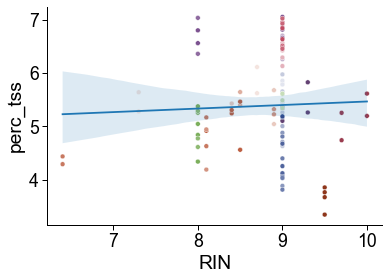

% genes in splicing vs. RIN spearman rho: 0.0334151098328015, pval:0.7413680916604557
% genes in splicing vs. RIN pearson r: 0.04680507898891449, pval:0.7413680916604557


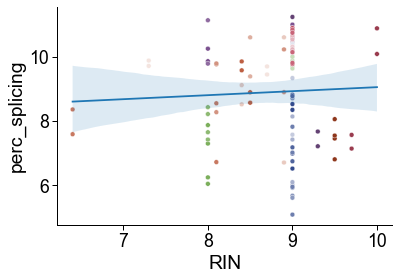

% genes in tes vs. RIN spearman rho: 0.31858852748229316, pval:0.0012359909876584422
% genes in tes vs. RIN pearson r: 0.35748636311172266, pval:0.0012359909876584422


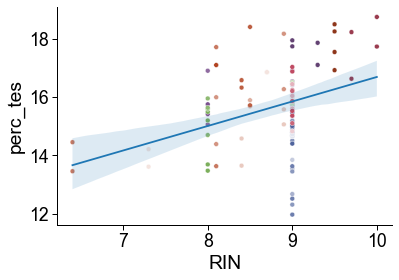

% genes in mixed vs. RIN spearman rho: -0.028460092561415223, pval:0.778649252521316
% genes in mixed vs. RIN pearson r: -0.03787848353377237, pval:0.778649252521316


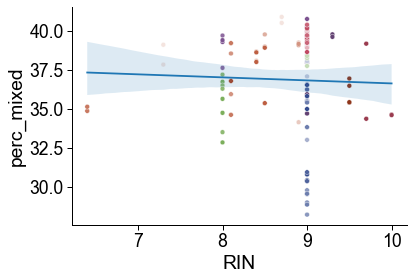

% genes in simple vs. RIN spearman rho: -0.055808102893263004, pval:0.5812946285061165
% genes in simple vs. RIN pearson r: -0.08287375134538896, pval:0.5812946285061165


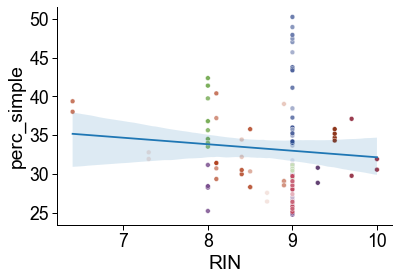

<Figure size 432x288 with 0 Axes>

In [21]:
sectors =  get_sector_colors()[1]
df['n_tot'] = df[sectors].sum(axis=1)
df = df.loc[df.RIN.notnull()]
c_dict, order = get_biosample_colors(species='mouse')
for s in sectors:
    df[f'perc_{s}'] = (df[s]/df['n_tot'])*100
    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    
    y = f'perc_{s}'
    x = 'RIN'
    ax = sns.scatterplot(df, y=y, x=x, hue='sample', palette=c_dict)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend_.remove()
    
    rho, p = st.spearmanr(df[x].tolist(), df[y].tolist())
    print(f'% genes in {s} vs. RIN spearman rho: {rho}, pval:{p}')
    r, p2 = st.pearsonr(df[x].tolist(), df[y].tolist())
    print(f'% genes in {s} vs. RIN pearson r: {r}, pval:{p}')
    
                        
    ax = sns.regplot(df, y=y, x=x, scatter=False)
    plt.show()
    plt.clf()
    
    
